IMPORTING LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

LOADING DATASET

In [2]:
# Load Dataset

df = pd.read_csv("/content/diabetic_data.csv.zip")
print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (101766, 50)
   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No 

In [3]:
# Dataset Information

print(df.info())
print(df.describe())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [4]:
# Drop unnecessary columns

cols_to_drop = ['weight', 'payer_code', 'medical_specialty', 'encounter_id', 'patient_nbr']     #irrevalent columns
cols_to_drop = ['max_glu_serum', 'A1Cresult']   # since more than 83% of values are missing
df.drop(columns=[c for c in cols_to_drop if c in df.columns], inplace=True)
df.drop_duplicates(inplace=True)
print(df['readmitted'].value_counts())

readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64


In [5]:
# cleaning the target column

df['readmitted'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0 )      # 1 = readmitted within 30 days, 0 = otherwise
print(df['readmitted'].value_counts())


readmitted
0    90409
1    11357
Name: count, dtype: int64


CORRELATION HEATMAP

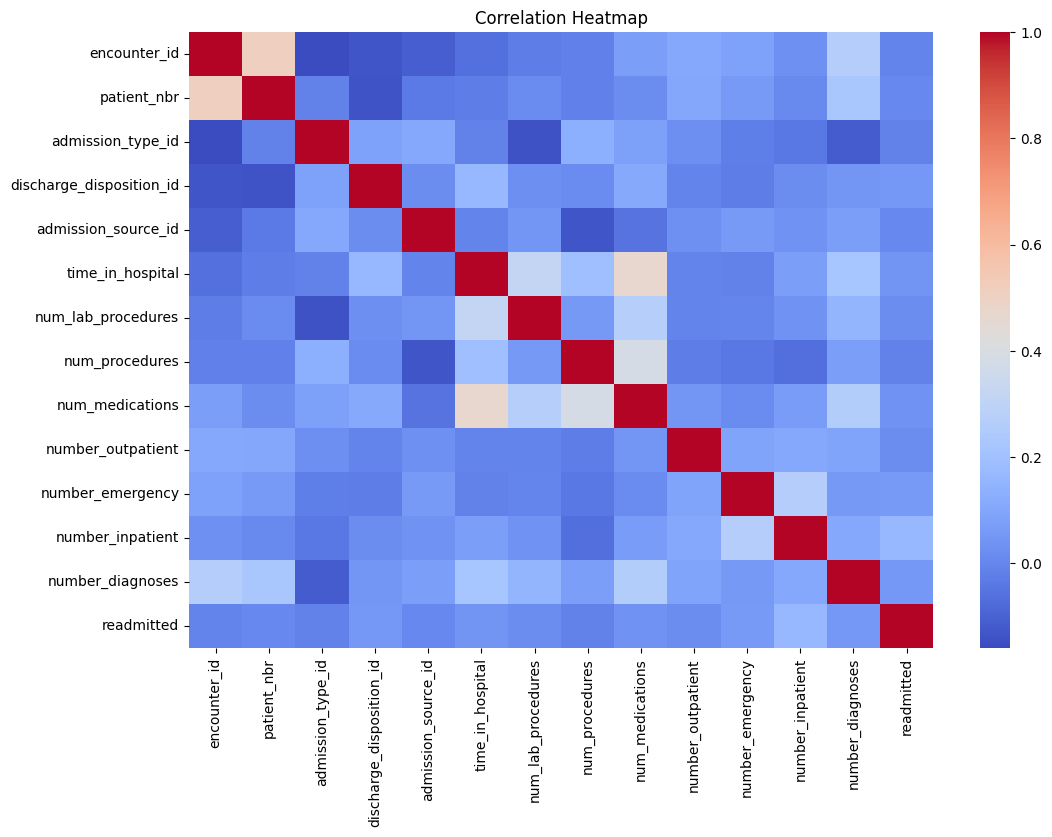

In [6]:
# Correlation Heatmap

numeric_cols = df.select_dtypes(include=['int64','float64']).columns
plt.figure(figsize=(12,8))
sns.heatmap(df[numeric_cols].corr(), cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


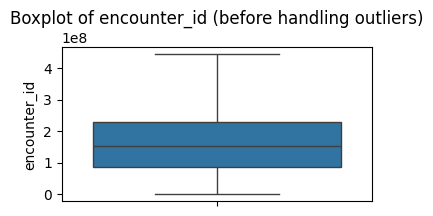

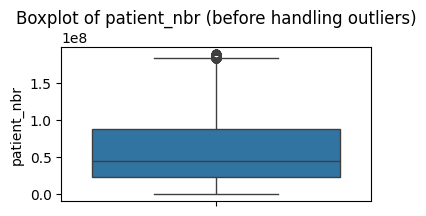

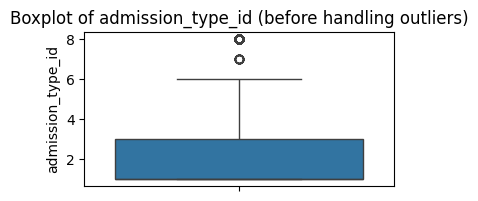

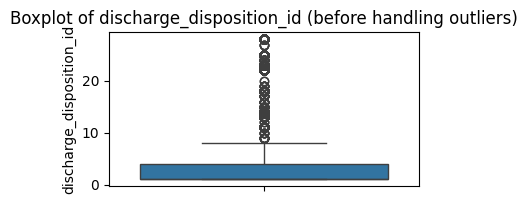

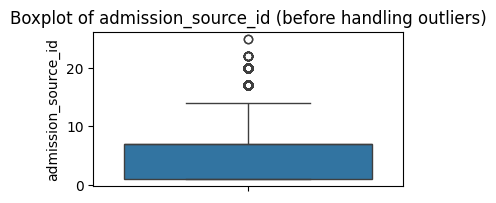

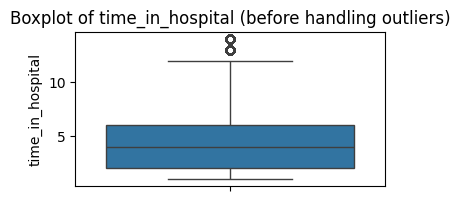

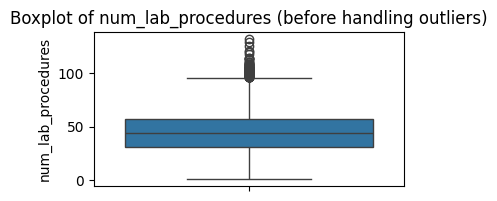

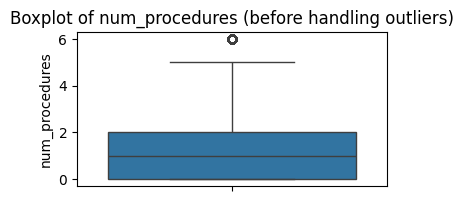

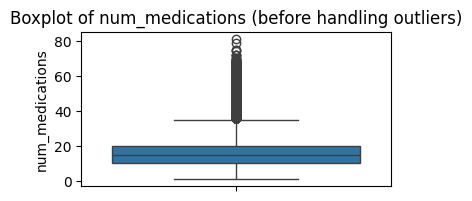

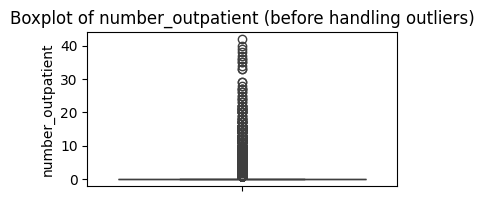

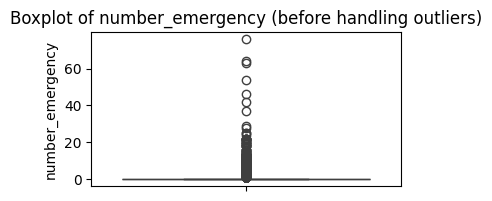

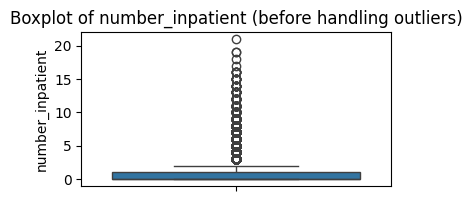

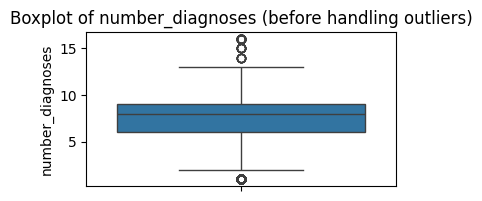

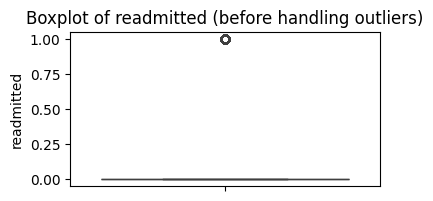

In [7]:
# Boxplot before handling outliers

for col in numeric_cols:
    plt.figure(figsize=(4,2))
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col} (before handling outliers)')
    plt.show()

HANDLING OUTLIERS(CAPPING)

In [8]:
# Handling outliers using Capping

numeric_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col != 'readmitted']      #excluding the target

def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    df[column] = df[column].clip(lower, upper).astype(df[column].dtype)    #converting to original dtype
    return df

for col in numeric_cols:
    df = cap_outliers(df, col)



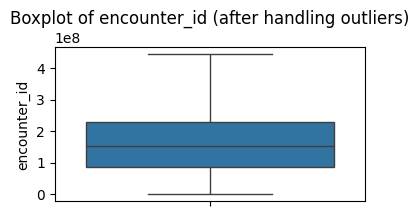

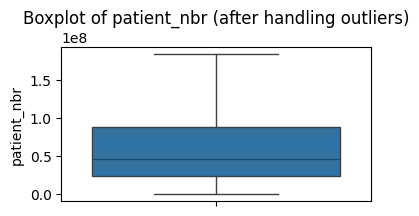

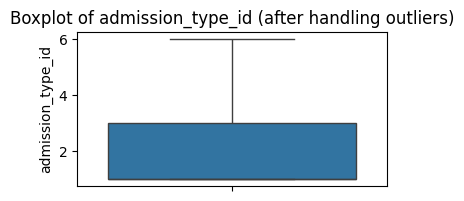

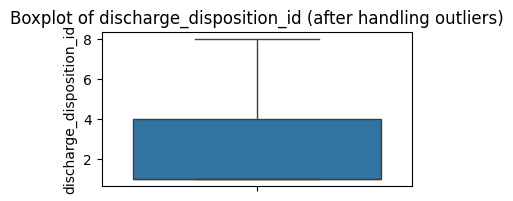

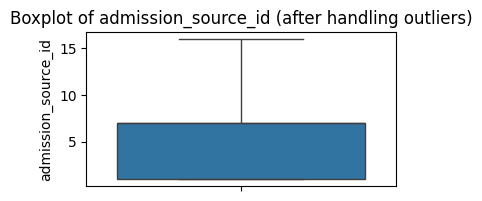

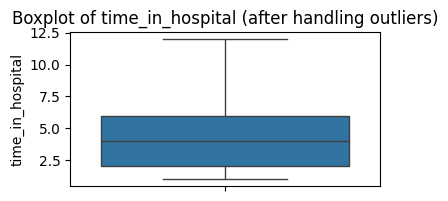

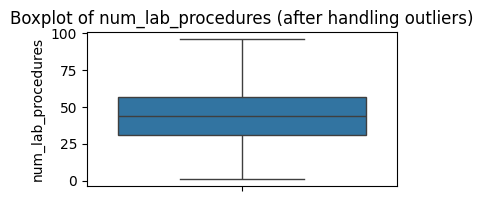

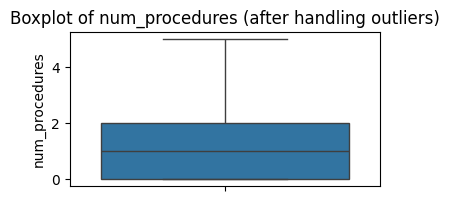

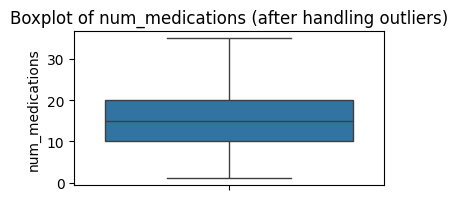

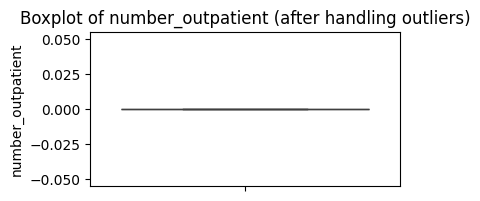

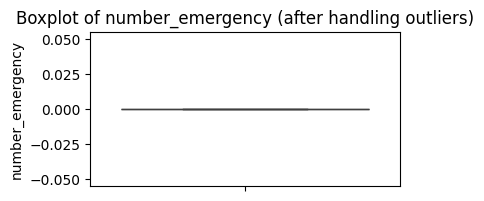

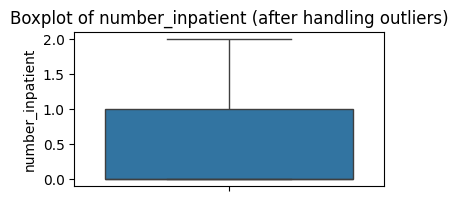

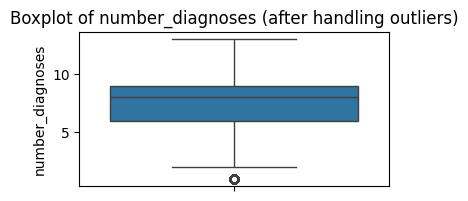

In [9]:

# Boxplot after handling outliers

for col in numeric_cols:
    plt.figure(figsize=(4,2))
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col} (after handling outliers)')
    plt.show()

In [10]:
df['readmitted'].value_counts()

,count
readmitted,
0,90409
1,11357


ENCODING

In [11]:

y = df['readmitted']
X = df.drop(columns=['readmitted'])

# Encode
cat_cols = X.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in cat_cols:
    X[col] = le.fit_transform(X[col].astype(str))



SPLITTING DATASET

In [12]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train class distribution:\n", y_train.value_counts())
print("Test class distribution:\n", y_test.value_counts())


Train class distribution:
 readmitted
0    72326
1     9086
Name: count, dtype: int64
Test class distribution:
 readmitted
0    18083
1     2271
Name: count, dtype: int64


SCALING

In [13]:
# Scaling

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


In [14]:
X_train.shape, X_test.shape        #checking the shape

((81412, 47), (20354, 47))

FEATURE SELECTION

In [15]:
# Feature Selection
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)


numeric_cols_array = np.array(numeric_cols)

X_train_reduced = pd.DataFrame(
    selector.fit_transform(X_train[numeric_cols]),
    columns=numeric_cols_array[selector.get_support()]
)

X_test_reduced = pd.DataFrame(
    selector.transform(X_test[numeric_cols]),
    columns=numeric_cols_array[selector.get_support()]
)


In [16]:

print(y_train.value_counts())


readmitted
0    72326
1     9086
Name: count, dtype: int64


SMOTTING

In [17]:
# Using SMOTE to balance

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_reduced, y_train)
print("After SMOTE, train class distribution:\n", pd.Series(y_train_res).value_counts())

After SMOTE, train class distribution:
 readmitted
0    72326
1    72326
Name: count, dtype: int64


TRAINING AND EVALUATION OF MODELS

In [18]:
# Train & Evaluate Models

models = {
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=200, class_weight='balanced'),
    "Logistic Regression": LogisticRegression(max_iter=500, class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "SVM": SVC(max_iter=5000, random_state=42, class_weight='balanced')
}
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test_reduced)
    print(f"\n{name} Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))



Random Forest Accuracy: 0.8781074972978284
Confusion Matrix:
 [[17778   305]
 [ 2176    95]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.98      0.93     18083
           1       0.24      0.04      0.07      2271

    accuracy                           0.88     20354
   macro avg       0.56      0.51      0.50     20354
weighted avg       0.82      0.88      0.84     20354


Logistic Regression Accuracy: 0.6519111722511546
Confusion Matrix:
 [[12056  6027]
 [ 1058  1213]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.67      0.77     18083
           1       0.17      0.53      0.26      2271

    accuracy                           0.65     20354
   macro avg       0.54      0.60      0.51     20354
weighted avg       0.84      0.65      0.72     20354


Gradient Boosting Accuracy: 0.8600275130195539
Confusion Matrix:
 [[17315   768]
 [ 2081   190]]
Classi

BEST MODEL

In [20]:
scores = {}

for name, model in models.items():
    model.fit(X_train_reduced, y_train)
    scores[name] = accuracy_score(y_test, model.predict(X_test_reduced))

best_model = max(scores, key=scores.get)

print("Best Model:", best_model)
print("Accuracy:", scores[best_model])


Best Model: Gradient Boosting
Accuracy: 0.8884740100226
